# Exploratory Data Analysis
## Detection and Classification of Macropodidae

In [94]:
import os
import re
from collections import Counter, OrderedDict

%matplotlib inline
from easyimages import EasyImageList
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from custom_utils import ROOT_DIR, read_yaml

In [44]:
IMAGE_DIR = os.path.join(ROOT_DIR, 'data', 'roboflow', 'all2', 'images')
LABEL_DIR = os.path.join(ROOT_DIR, 'data', 'roboflow', 'all2', 'labels')

all_labels = os.listdir(LABEL_DIR)
all_images = os.listdir(IMAGE_DIR)

yaml_data = read_yaml()
species = yaml_data['names']

## Visual data inspection

In [10]:
Li = EasyImageList.from_folder(IMAGE_DIR)
Li.symlink_images()
Li.html()

## Image sizes and aspect ratios

In the real world, datasets are unlikely to contain images of the same  sizes and aspect ratios. Inspecting basic datasets statistics such as aspect ratios, image widths and heights will help you make important decisions:

* Can you and should you? do destructive resizing ? (destructive means resizing that changes the AR) 
* For non-destructive resizing what should be your desired output resolution and amount of padding? Deep Learning models might have hyper parameters you have to tune depending on the above  (for instance anchor size and ratios)  or they might even have strong requirements when it comes to minimum input image size.  


In [11]:
from PIL import Image

aspect_ratio_list = []
width_height_list = []

for img_name in all_images:
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)
    
    width, height = img.size
    width_height_list.append((width, height))
    
    aspect_ratio = width/height
    aspect_ratio_list.append(aspect_ratio)

print(f' aspect ratio: {set(aspect_ratio_list)}\n',
      f'width, height: {set(width_height_list)}')

 aspect ratio: {1.0}
 width, height: {(640, 640)}


All images are of size 640 x 640 with an aspect ratio of 1.

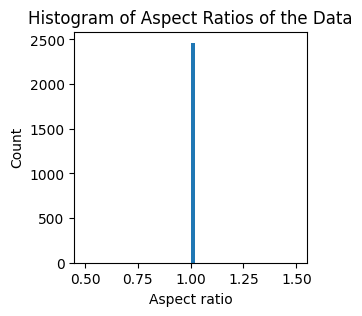

In [16]:
# plot aspect ratios
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(aspect_ratio_list, 50)
ax.set_xlabel('Aspect ratio')
ax.set_ylabel('Count')
ax.set_title('Histogram of Aspect Ratios of the Data')
plt.show()

## Label (objects) sizes and dimensions

Here we start looking at our targets (labels). Particularly we are interested in knowing how the sizes and aspect ratios are distributed.  

Why is this important?

Depending on your modelling approach most of the frameworks will have design limitations. As I mentioned earlier, those models are designed to perform well on benchmark datasets. If for whatever reason your data is different, training them might be impossible.  Let’s have a look at a default config for Retinanet from detectron2:

ANCHOR_GENERATOR:
    SIZES: !!python/object/apply:eval ["[[x, x * 2**(1.0/3), x * 2**(2.0/3) ] for x in [32, 64, 128, 256, 512 ]]"]

What you can see there is, that for different feature maps the anchors we generate will have a certain size range:

* for instance, if your dataset contains only really big objects – it might be possible to simplify the model a lot, on the other side let’s assume you have small images with small objects (for instance 10x10px) given this config it can happen you will not be able to train the model.

The most important things to consider when it comes to box or mask dimensions are:
* Aspect ratios 
* Size (Area)

In [83]:
area_list = []
labels_list = []
aspect_ratio_list = []


for img_name in all_images:
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)
    
    width, height = img.size

for lbl_name, img_name in zip(all_labels, all_images):
    
    lbl_path = os.path.join(LABEL_DIR, lbl_name)
    img_path = os.path.join(IMAGE_DIR, img_name)

    img = Image.open(img_path)
    image_width, image_height = img.size
    
    with open(lbl_path, 'rb') as f:
        lines = f.readlines()

        for line in lines:
            bbox = list(map(float, line.strip().split()))
            label, x_center, y_center, box_width, box_height = bbox
            
            # reformat the data from relative to absolute values in pixels
            x1 = int((x_center - box_width / 2) * image_width)
            y1 = int((y_center - box_height / 2) * image_height)
            x2 = int((x_center + box_width / 2) * image_width)
            y2 = int((y_center + box_height / 2) * image_height)
            
            area = (x2-x1) * (y2-y1)
            area_list.append(area)
            
            labels_list.append(label)
            aspect_ratio_list.append((box_width/box_height))

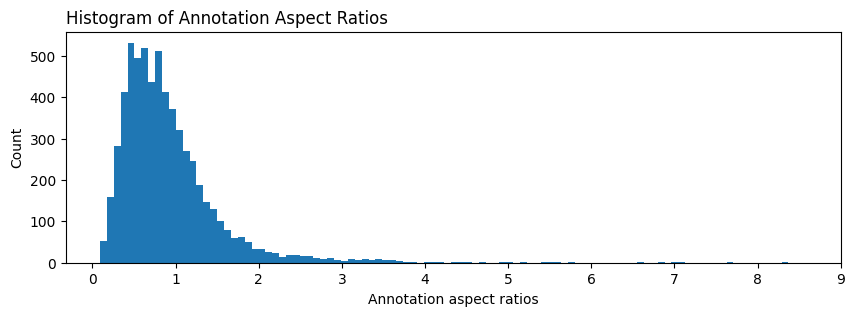

In [84]:
# plot histogram of annotation aspect ratios

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(aspect_ratio_list, bins=100)
ax.set_title('Histogram of Annotation Aspect Ratios', loc= 'left')
ax.set_ylabel('Count')
ax.set_xlabel('Annotation aspect ratios')
ax.set_xticks([x for x in range(10)])
plt.show()

In [85]:

df = pd.DataFrame({'Area': area_list, 'Species':labels_list})
df = df.groupby('Species').mean()
df = df.sort_values('Area', ascending=False)

for idx, label in enumerate(df.index): 
    df.loc[idx, 'Species'] = species[label]

df = df.reset_index(drop=True)
df

,Area,Species
0,92102.927083,Macropus fuliginosus
1,62929.392111,Notamacropus rufogriseus
2,51354.034995,Wallabia bicolor
3,50424.862665,Onychogalea fraenata
4,50069.679191,Macropus giganteus
5,42638.335626,Ospranter rufus
6,39424.367915,Petrogale penicillata


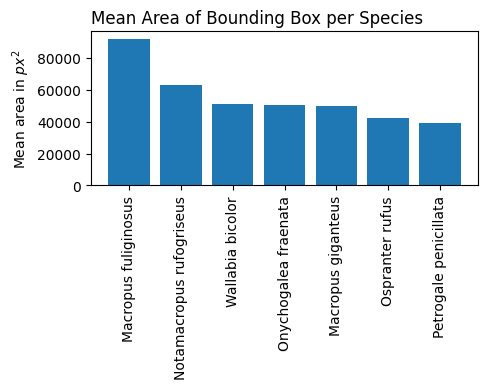

In [87]:
fig, ax = plt.subplots(figsize=(5,2))
x = np.arange(len(df))

for i in range(len(df)):
    ax.bar(df.loc[i, 'Species'], df.loc[i, 'Area'], color='#1f77b4')

ax.set_title('Mean Area of Bounding Box per Species', loc='left')
ax.set_ylabel('Mean area in $px^2$')
ax.set_xticks(x, df['Species'], rotation=90)

plt.show()

[Faster R-CNN](https://arxiv.org/abs/1506.01497) is an anchor-based model, so it is important to examine the ratios of the annotated data to ensure that the hyperparameters for the model match the distributions and expectations of the dataset.

As can be seen in the histogram, the vast majority of the bounding boxes have aspect ratios between 0 and 2, which can help to configure the [anchor generator](https://github.com/pytorch/vision/blob/a7e4fbdc925a5968988ccadd6dffe7abe274dcdc/torchvision/models/detection/anchor_utils.py#L10), which is essential for the model. It can also be seen that there is difference in the size of the areas of the bounding boxes between the species:
* The mean areas of the bounding boxes of ***Macropus fuliginosus*** are more than twice as large as those of ***Petrogale penicillata***.

## Victorian **Macropodidae**

In [229]:
species = yaml_data['names']
species

{0: 'Macropus fuliginosus',
 1: 'Macropus giganteus',
 2: 'Notamacropus rufogriseus',
 3: 'Onychogalea fraenata',
 4: 'Ospranter rufus',
 5: 'Petrogale penicillata',
 6: 'Wallabia bicolor'}

In [230]:
labels = []

# iterate over all label txt-files
for file in all_labels:
    file_path = os.path.join(LABEL_DIR, file)

    with open(file_path, 'rb') as txt_file:
        lines = txt_file.readlines()
        
        for line in lines: 
            bbox = list(map(float, line.strip().split()))
            
            # unpack bbox
            label, x_center, y_center, box_width, box_height = bbox
            labels.append(species[int(label)])

# count number of specimen in images according to name of the species
specimen_in_images = Counter()
for specimen in labels: specimen_in_images[specimen] += 1

specimen_in_images = dict(specimen_in_images)
specimen_in_images

{'Macropus fuliginosus': 983,
 'Onychogalea fraenata': 576,
 'Macropus giganteus': 1041,
 'Ospranter rufus': 943,
 'Wallabia bicolor': 1038,
 'Notamacropus rufogriseus': 727,
 'Petrogale penicillata': 862}

In [231]:
# iterate over all label txt-files
image_labels = []
for file in all_images:
    label = re.split('_\d{3}', file)[0]
    image_labels.append(label)
    
cnt_labels = Counter()
for label in image_labels: cnt_labels[label]+=1


image_count = {}
for specimen, count in cnt_labels.items():
    specimen = specimen.replace('_', ' ').capitalize()
    if specimen in species.values():
        image_count[specimen] = count
        
image_count

{'Macropus fuliginosus': 312,
 'Macropus giganteus': 303,
 'Wallabia bicolor': 445,
 'Petrogale penicillata': 302,
 'Onychogalea fraenata': 126,
 'Notamacropus rufogriseus': 146}

In [232]:
# prepare data for plotting
list_count_in_image=[]
list_number_images=[]
list_order_species=[]

for specimen in specimen_in_images:
    count_in_image = specimen_in_images[specimen]
    list_count_in_image.append(count_in_image)
    
    number_images = image_count.get(specimen)
    if not number_images: number_images=0
    list_number_images.append(number_images)
    
    list_order_species.append(specimen)
    
data = {'specimen_in_image': list_count_in_image,
        'images_with_specimen': list_number_images}
data

{'specimen_in_image': [983, 576, 1041, 943, 1038, 727, 862],
 'images_with_specimen': [312, 126, 303, 0, 445, 146, 302]}

In [106]:
species = [species for species in cnt_labels if cnt_labels[species]>1]
species = [specimen.replace('_', ' ').capitalize() for specimen in species]
species

['Macropus fuliginosus',
 'Macropus giganteus',
 'Wallabia bicolor',
 'Osphranter rufus',
 'Petrogale penicillata',
 'Onychogalea fraenata',
 'Notamacropus rufogriseus',
 'Macropus rufogriseus',
 'Onychogalae']

## Balance of the Species Classes
Visualize Specimen and Image Count

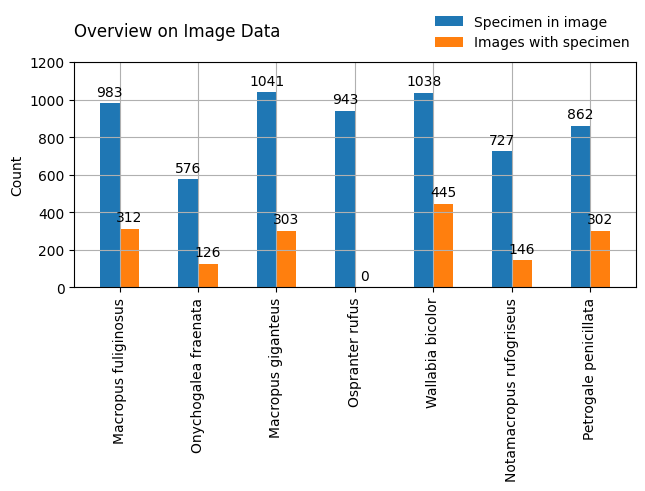

In [270]:
x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    attribute = attribute.replace('_', ' ').capitalize()
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Overview on Image Data', loc='left', y=1.08)
ax.set_xticks(x+width/2, list_order_species, rotation=90)
ax.legend(bbox_to_anchor=(0.62, 1), frameon=False)
ax.set_ylim(0, 1200)
ax.grid()

plt.show()

The figure shows that there are many images in the database that have more than one specimen in the image.

## Per-Class Metrics
Looking at per-class metrics is extremely valuable, as it might give you important insights:

* help you compose a new dataset better 
* make better decisions when it comes to data augmentation, data sampling etc.

In [97]:
Image(url='https://lh3.googleusercontent.com/CMGYhd1jMrIAu8EEjUDGSKPKtT1kLjg10Wt4BZ2AQfKAqdVIEn54thPa0Kh8chaFVxRsMWXUYGuuHMDPkq8xp84USLOTNFYJeL36GSnd53BUCU55cQsPd9IVip7FcHI_d6etDQE4')

In [ ]:
<img src="https://lh3.googleusercontent.com/CMGYhd1jMrIAu8EEjUDGSKPKtT1kLjg10Wt4BZ2AQfKAqdVIEn54thPa0Kh8chaFVxRsMWXUYGuuHMDPkq8xp84USLOTNFYJeL36GSnd53BUCU55cQsPd9IVip7FcHI_d6etDQE4">

Fig 16. Per class AP
Figure 16. gives you a lot of useful informations there are few things you might consider:

* Add more data to low performing classes
* For classes that score well, maybe you can consider downsampling them  to speed up the training and maybe help with the performance of other less frequent classes.
* Spot any obvious correlations for instance classes with small objects performing poorly.

## References
[How to Do Data Exploration for Image Segmentation and Object Detection (Things I Had to Learn the Hard Way)](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection) 